In [ ]:
!pip install shap lime scikit-learn matplotlib

In [ ]:
!pip show lime shap


Name: lime
Version: 0.2.0.1
Summary: Local Interpretable Model-Agnostic Explanations for machine learning classifiers
Home-page: http://github.com/marcotcr/lime
Author: Marco Tulio Ribeiro
Author-email: marcotcr@gmail.com
License: BSD
Location: /usr/local/lib/python3.11/dist-packages
Requires: matplotlib, numpy, scikit-image, scikit-learn, scipy, tqdm
Required-by: 
---
Name: shap
Version: 0.47.1
Summary: A unified approach to explain the output of any machine learning model.
Home-page: 
Author: 
Author-email: Scott Lundberg <slund1@cs.washington.edu>
License: MIT License
Location: /usr/local/lib/python3.11/dist-packages
Requires: cloudpickle, numba, numpy, packaging, pandas, scikit-learn, scipy, slicer, tqdm, typing-extensions
Required-by: 


In [ ]:
import shap
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


In [ ]:
# Load dataset with human-readable columns
X_human, _ = shap.datasets.adult(display=True)
X, y = shap.datasets.adult(display=False)
X_df = pd.DataFrame(X, columns=X_human.columns)
y_series = pd.Series(y, name="income")


In [ ]:
print("Feature shape:", X_df.shape)
print("Target shape:", y_series.shape)
X_df.head()

Feature shape: (32561, 12)
Target shape: (32561,)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


In [ ]:
UID = 18493283

X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_series, test_size=0.2, random_state=UID
)


In [ ]:
summary_df = X_df.describe().T[['min', 'max']]
summary_df['data_type'] = X_df.dtypes
summary_df.reset_index(inplace=True)
summary_df.rename(columns={'index': 'feature'}, inplace=True)

from IPython.display import display
display(summary_df)

,feature,min,max,data_type
0,Age,17.0,90.0,float32
1,Workclass,0.0,8.0,int8
2,Education-Num,1.0,16.0,float32
3,Marital Status,0.0,6.0,int8
4,Occupation,0.0,14.0,int8
5,Relationship,0.0,5.0,int64
6,Race,0.0,4.0,int8
7,Sex,0.0,1.0,int8
8,Capital Gain,0.0,99999.0,float32
9,Capital Loss,0.0,4356.0,float32


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


In [ ]:
UID = 18493283
gb_model = GradientBoostingClassifier(random_state=UID)
mlp_model = MLPClassifier(random_state=UID, max_iter=300)


In [ ]:
gb_model.fit(X_train, y_train)

gb_train_preds = gb_model.predict(X_train)
gb_test_preds = gb_model.predict(X_test)

gb_train_acc = accuracy_score(y_train, gb_train_preds)
gb_test_acc = accuracy_score(y_test, gb_test_preds)

print("Gradient Boosting Train Accuracy:", gb_train_acc)
print("Gradient Boosting Test Accuracy:", gb_test_acc)


Gradient Boosting Train Accuracy: 0.8693565724815725
Gradient Boosting Test Accuracy: 0.8685705512052817


In [ ]:
mlp_model.fit(X_train, y_train)

mlp_train_preds = mlp_model.predict(X_train)
mlp_test_preds = mlp_model.predict(X_test)

mlp_train_acc = accuracy_score(y_train, mlp_train_preds)
mlp_test_acc = accuracy_score(y_test, mlp_test_preds)

print("MLP Train Accuracy:", mlp_train_acc)
print("MLP Test Accuracy:", mlp_test_acc)


MLP Train Accuracy: 0.8369548525798526
MLP Test Accuracy: 0.8395516658989712


In [ ]:
#SHAP for Gradient Boosting

In [ ]:
import numpy as np
np.random.seed(UID)
sample_indices = np.random.choice(X_test.index, size=100, replace=False)

X_sample = X_test.loc[sample_indices]
y_sample = y_test.loc[sample_indices]


In [ ]:
import shap
shap_explainer_gb = shap.Explainer(gb_model, X_train)
shap_values_gb = shap_explainer_gb(X_sample)


In [ ]:
age_idx = list(X_sample.columns).index("Age")
hours_idx = list(X_sample.columns).index("Hours per week")

age_vals = X_sample["Age"].values
hours_vals = X_sample["Hours per week"].values
age_importances_gb_shap = shap_values_gb.values[:, age_idx]
hours_importances_gb_shap = shap_values_gb.values[:, hours_idx]


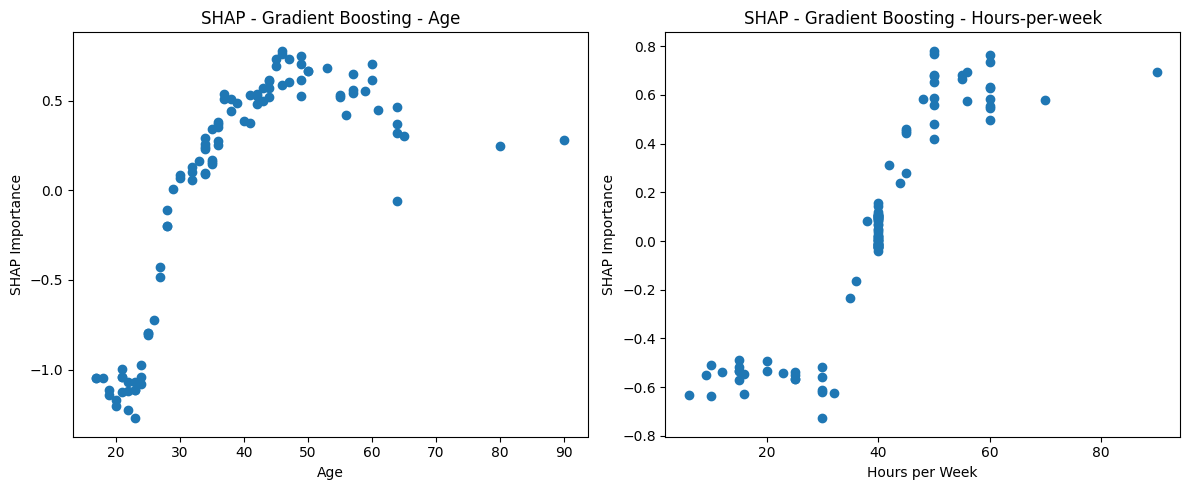

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(age_vals, age_importances_gb_shap)
plt.xlabel("Age")
plt.ylabel("SHAP Importance")
plt.title("SHAP - Gradient Boosting - Age")

plt.subplot(1, 2, 2)
plt.scatter(hours_vals, hours_importances_gb_shap)
plt.xlabel("Hours per Week")
plt.ylabel("SHAP Importance")
plt.title("SHAP - Gradient Boosting - Hours-per-week")

plt.tight_layout()
plt.show()


In [ ]:
#SHAP Explanations for MLPClassifier

In [ ]:
background_sample = X_train.sample(n=100, random_state=UID)


In [ ]:
shap_explainer_mlp = shap.KernelExplainer(mlp_model.predict_proba, background_sample)

shap_values_mlp = shap_explainer_mlp.shap_values(X_sample)
shap_values_mlp=shap_values_mlp
print(type(shap_values_mlp))
print(len(shap_values_mlp))
print(shap_values_mlp[1].shape)

  0%|          | 0/100 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
100
(12, 2)


In [ ]:
shap_class_1 = shap_values_mlp[1]


In [ ]:
print(shap_class_1.shape)


(12, 2)


In [ ]:
shap_class_1 = shap_values_mlp

age_idx = list(X_sample.columns).index("Age")
hours_idx = list(X_sample.columns).index("Hours per week")

age_vals = X_sample["Age"].values
hours_vals = X_sample["Hours per week"].values

age_importances_mlp_shap = shap_class_1[:,age_idx,1]
hours_importances_mlp_shap = shap_class_1[:,hours_idx,1]

print(age_importances_mlp_shap.shape)


(100,)


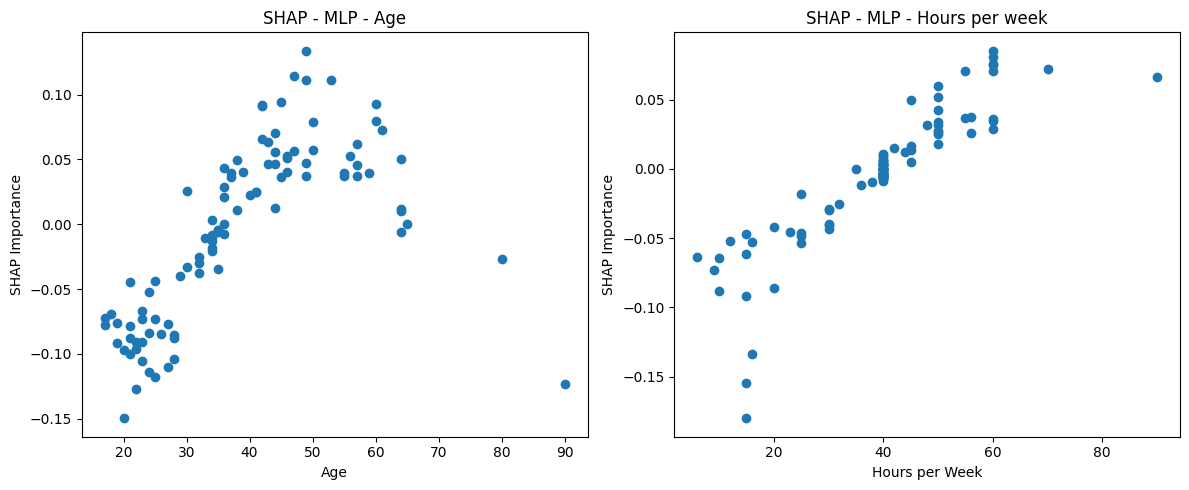

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(age_vals, age_importances_mlp_shap)
plt.xlabel("Age")
plt.ylabel("SHAP Importance")
plt.title("SHAP - MLP - Age")


plt.subplot(1, 2, 2)
plt.scatter(hours_vals, hours_importances_mlp_shap)
plt.xlabel("Hours per Week")
plt.ylabel("SHAP Importance")
plt.title("SHAP - MLP - Hours per week")

plt.tight_layout()
plt.show()


In [ ]:
#LIME GB

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

X_train_np = X_train.values
X_sample_np = X_sample.values

lime_explainer = LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=X_train.columns.tolist(),
    class_names=["<=50K", ">50K"],
    mode="classification",
    feature_selection='auto',
    discretize_continuous=True,
    random_state=UID
)




In [ ]:
age_importances_gb_lime = []
hours_importances_gb_lime = []

for i in range(100):
    exp = lime_explainer.explain_instance(
        data_row=X_sample_np[i],
        predict_fn=gb_model.predict_proba,
        num_features=12
    )

    exp_features = exp.as_list()
    keys = [k for k, _ in exp_features]

    if i == 0:
        print("Explanation keys (first sample):")
        for k in keys:
            print(k)

    age_score = 0
    for k, v in exp_features:
        if "age" in k.lower():
            age_score = v
            break

    hours_score = 0
    for k, v in exp_features:
        if "hours-per-week" in k.lower() or "hours per week" in k.lower():
            hours_score = v
            break

    age_importances_gb_lime.append(age_score)
    hours_importances_gb_lime.append(hours_score)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warni

Explanation keys (first sample):
Capital Gain <= 0.00
0.00 < Relationship <= 3.00
Education-Num <= 9.00
Capital Loss <= 0.00
Hours per week > 45.00
Country <= 39.00
Sex <= 0.00
3.00 < Occupation <= 7.00
Workclass <= 4.00
Marital Status > 4.00
28.00 < Age <= 37.00
Race <= 4.00


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warni

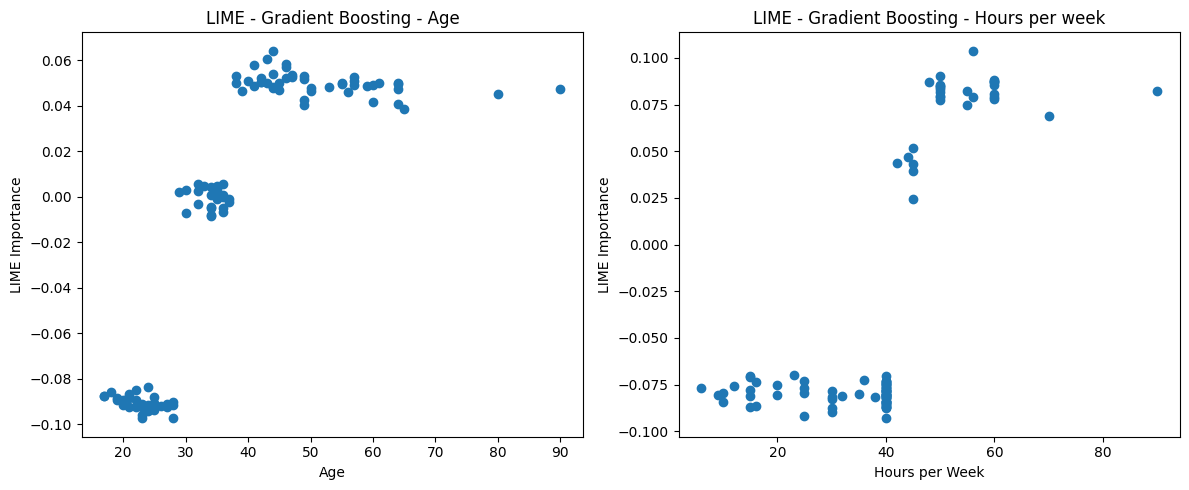

In [ ]:
age_vals = X_sample["Age"].values
hours_vals = X_sample["Hours per week"].values

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(age_vals, age_importances_gb_lime)
plt.xlabel("Age")
plt.ylabel("LIME Importance")
plt.title("LIME - Gradient Boosting - Age")

plt.subplot(1, 2, 2)
plt.scatter(hours_vals, hours_importances_gb_lime)
plt.xlabel("Hours per Week")
plt.ylabel("LIME Importance")
plt.title("LIME - Gradient Boosting - Hours per week")

plt.tight_layout()
plt.show()


In [ ]:
#LIME for MLP

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

X_train_np = X_train.values
X_sample_np = X_sample.values
feature_names = X_train.columns.tolist()

lime_explainer_mlp = LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=feature_names,
    class_names=["<=50K", ">50K"],
    mode="classification",
    feature_selection='auto',
    discretize_continuous=True,
    random_state=UID
)


In [ ]:
age_importances_mlp_lime = []
hours_importances_mlp_lime = []

for i in range(100):
    exp = lime_explainer_mlp.explain_instance(
        data_row=X_sample_np[i],
        predict_fn=mlp_model.predict_proba,
        num_features=len(feature_names)
    )

    exp_features = exp.as_list()

    age_score = 0
    for k, v in exp_features:
        if "age" in k.lower():
            age_score = v
            break

    hours_score = 0
    for k, v in exp_features:
        if "hours-per-week" in k.lower() or "hours per week" in k.lower():
            hours_score = v
            break

    age_importances_mlp_lime.append(age_score)
    hours_importances_mlp_lime.append(hours_score)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/v

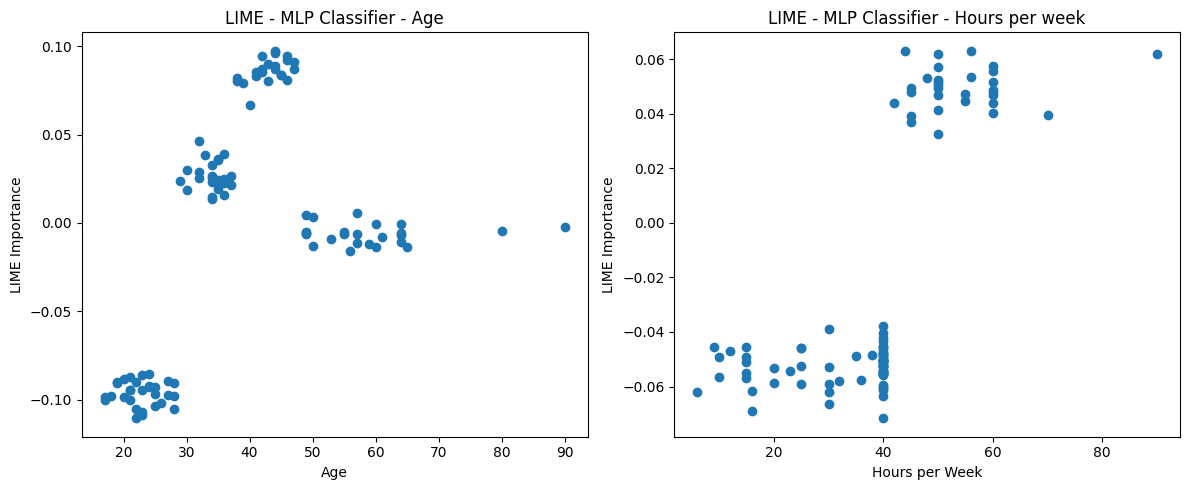

In [ ]:
age_vals = X_sample["Age"].values
hours_vals = X_sample["Hours per week"].values

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(age_vals, age_importances_mlp_lime)
plt.xlabel("Age")
plt.ylabel("LIME Importance")
plt.title("LIME - MLP Classifier - Age")
plt.subplot(1, 2, 2)
plt.scatter(hours_vals, hours_importances_mlp_lime)
plt.xlabel("Hours per Week")
plt.ylabel("LIME Importance")
plt.title("LIME - MLP Classifier - Hours per week")

plt.tight_layout()
plt.show()


In [ ]:
#GB single sample - SHAP

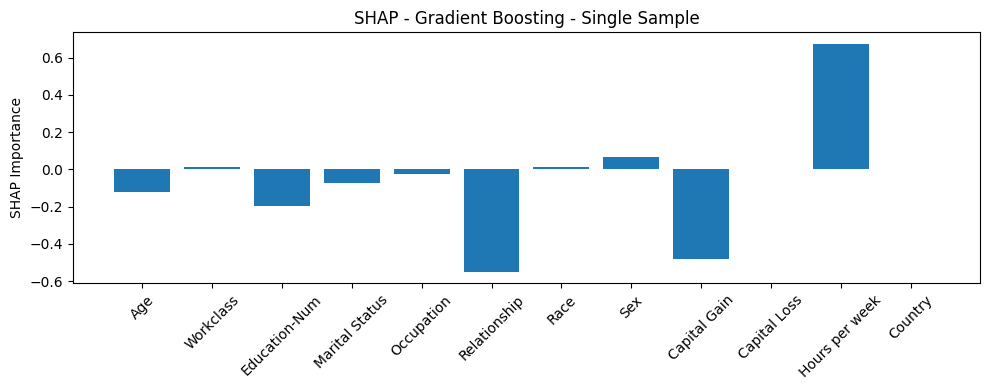

In [ ]:
import shap
shap_values_gb_single = shap_explainer_gb(X_single.to_frame().T)
shap_vals = shap_values_gb_single.values[0]
features = X_single.index
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.bar(features, shap_vals)
plt.xticks(rotation=45)
plt.title("SHAP - Gradient Boosting - Single Sample")
plt.ylabel("SHAP Importance")
plt.tight_layout()
plt.show()


In [ ]:
#MLP single sample - SHAP

  0%|          | 0/1 [00:00<?, ?it/s]

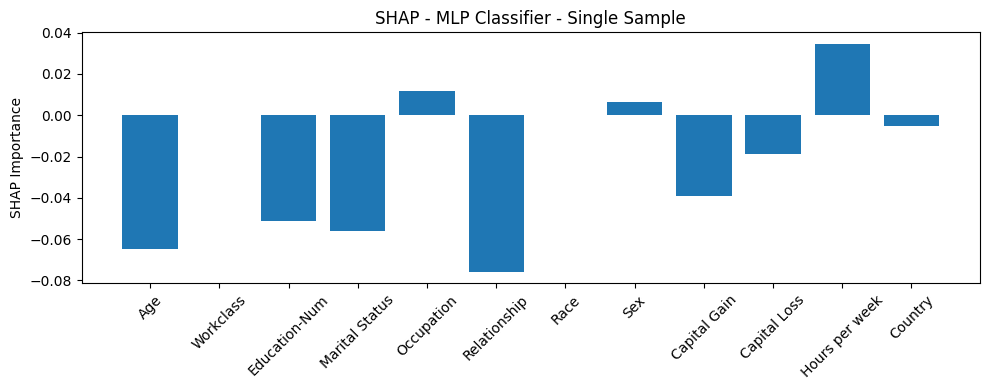

In [ ]:
shap_values_mlp_single = shap_explainer_mlp.shap_values(X_single.to_frame().T)
if isinstance(shap_values_mlp_single, list):
    shap_vals = shap_values_mlp_single[0][1]
else:
    shap_vals = shap_values_mlp_single[0, :, 1]

features = X_single.index

plt.figure(figsize=(10, 4))
plt.bar(features, shap_vals)
plt.xticks(rotation=45)
plt.title("SHAP - MLP Classifier - Single Sample")
plt.ylabel("SHAP Importance")
plt.tight_layout()
plt.show()


In [ ]:
#GB single sample - LIME

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


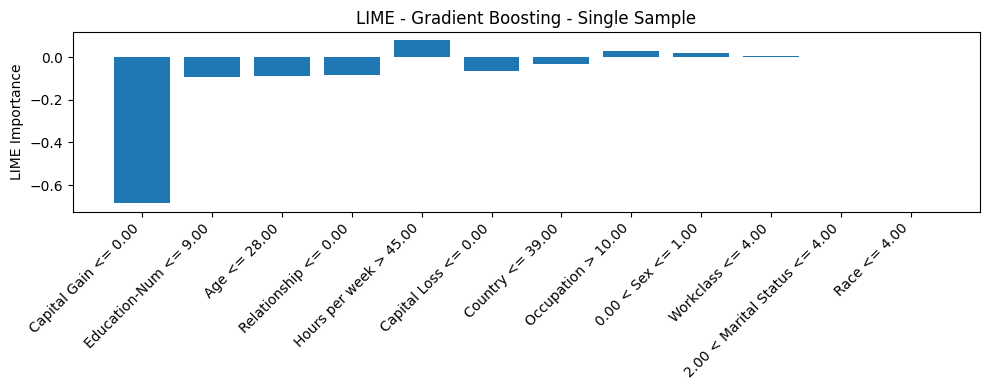

In [ ]:
exp_gb = lime_explainer.explain_instance(
    data_row=X_single.values,
    predict_fn=gb_model.predict_proba,
    num_features=12
)

exp_dict_gb = dict(exp_gb.as_list())
features = list(exp_dict_gb.keys())
importances = list(exp_dict_gb.values())

plt.figure(figsize=(10, 4))
plt.bar(features, importances)
plt.xticks(rotation=45, ha="right")
plt.title("LIME - Gradient Boosting - Single Sample")
plt.ylabel("LIME Importance")
plt.tight_layout()
plt.show()


In [ ]:
#MLP single sample - LIME

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


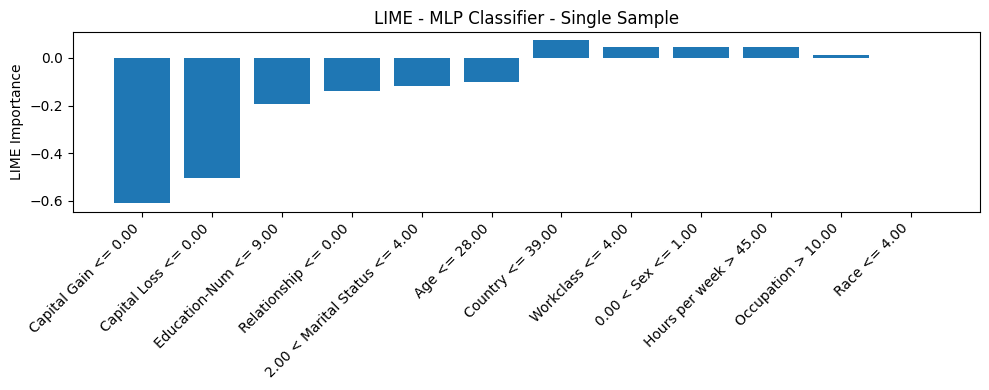

In [ ]:
exp_mlp = lime_explainer_mlp.explain_instance(
    data_row=X_single.values,
    predict_fn=mlp_model.predict_proba,
    num_features=12
)

exp_dict_mlp = dict(exp_mlp.as_list())
features = list(exp_dict_mlp.keys())
importances = list(exp_dict_mlp.values())

plt.figure(figsize=(10, 4))
plt.bar(features, importances)
plt.xticks(rotation=45, ha="right")
plt.title("LIME - MLP Classifier - Single Sample")
plt.ylabel("LIME Importance")
plt.tight_layout()
plt.show()
